In [1]:
# pip install --quiet scvi-tools

Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install --quiet git+https://github.com/theislab/scgen.git

Note: you may need to restart the kernel to use updated packages.


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


## Import the data

In [3]:
adata = anndata.read_h5ad("../human_immune.h5ad")
adata

/Users/sheena/Library/Python/3.9/lib/python/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/anndata/_io/specs/registry.py:256: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  return func(*args, **kwargs)
/Users/sheena/Library/Python/3.9/lib/python/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categori

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [4]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [6]:
# load the prediction results to adata
predict_labels = pd.read_csv("../R_human_immune/labels/TOSICA_human_immune_predict_obs.csv")

adata.obs['predict_labels'] = predict_labels['tosica_labels'].values

In [7]:
adata.obs['predict_labels'] = adata.obs['predict_labels'].astype('category')

In [8]:
adata.obs['predict_labels']

index
AAACCTGCAGCGAACA-1-Oetjen_A      CD16+ Monocytes
AAACCTGCATGTCCTC-1-Oetjen_A         CD4+ T cells
AAACCTGGTCGACTGC-1-Oetjen_A      CD14+ Monocytes
AAACCTGGTCGCTTCT-1-Oetjen_A      CD14+ Monocytes
AAACCTGTCCCGACTT-1-Oetjen_A            NKT cells
                                      ...       
Mono_nonclassical_S96-Villani    CD16+ Monocytes
Mono_nonclassical_S97-Villani    CD16+ Monocytes
Mono_nonclassical_S98-Villani    CD14+ Monocytes
Mono_nonclassical_S99-Villani    CD16+ Monocytes
Mono_nonclassical_S9-Villani     CD16+ Monocytes
Name: predict_labels, Length: 33506, dtype: category
Categories (16, object): ['CD10+ B cells', 'CD14+ Monocytes', 'CD16+ Monocytes', 'CD20+ B cells', ..., 'NK cells', 'NKT cells', 'Plasma cells', 'Plasmacytoid dendritic cells']

In [9]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [27]:
# Save the trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [11]:
# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [20]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [12]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [13]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [02:26<00:00,  7.21s/it, v_num=1, train_loss_step=489, train_loss_epoch=487]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:26<00:00,  7.32s/it, v_num=1, train_loss_step=489, train_loss_epoch=487]


In [14]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [15]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [16]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

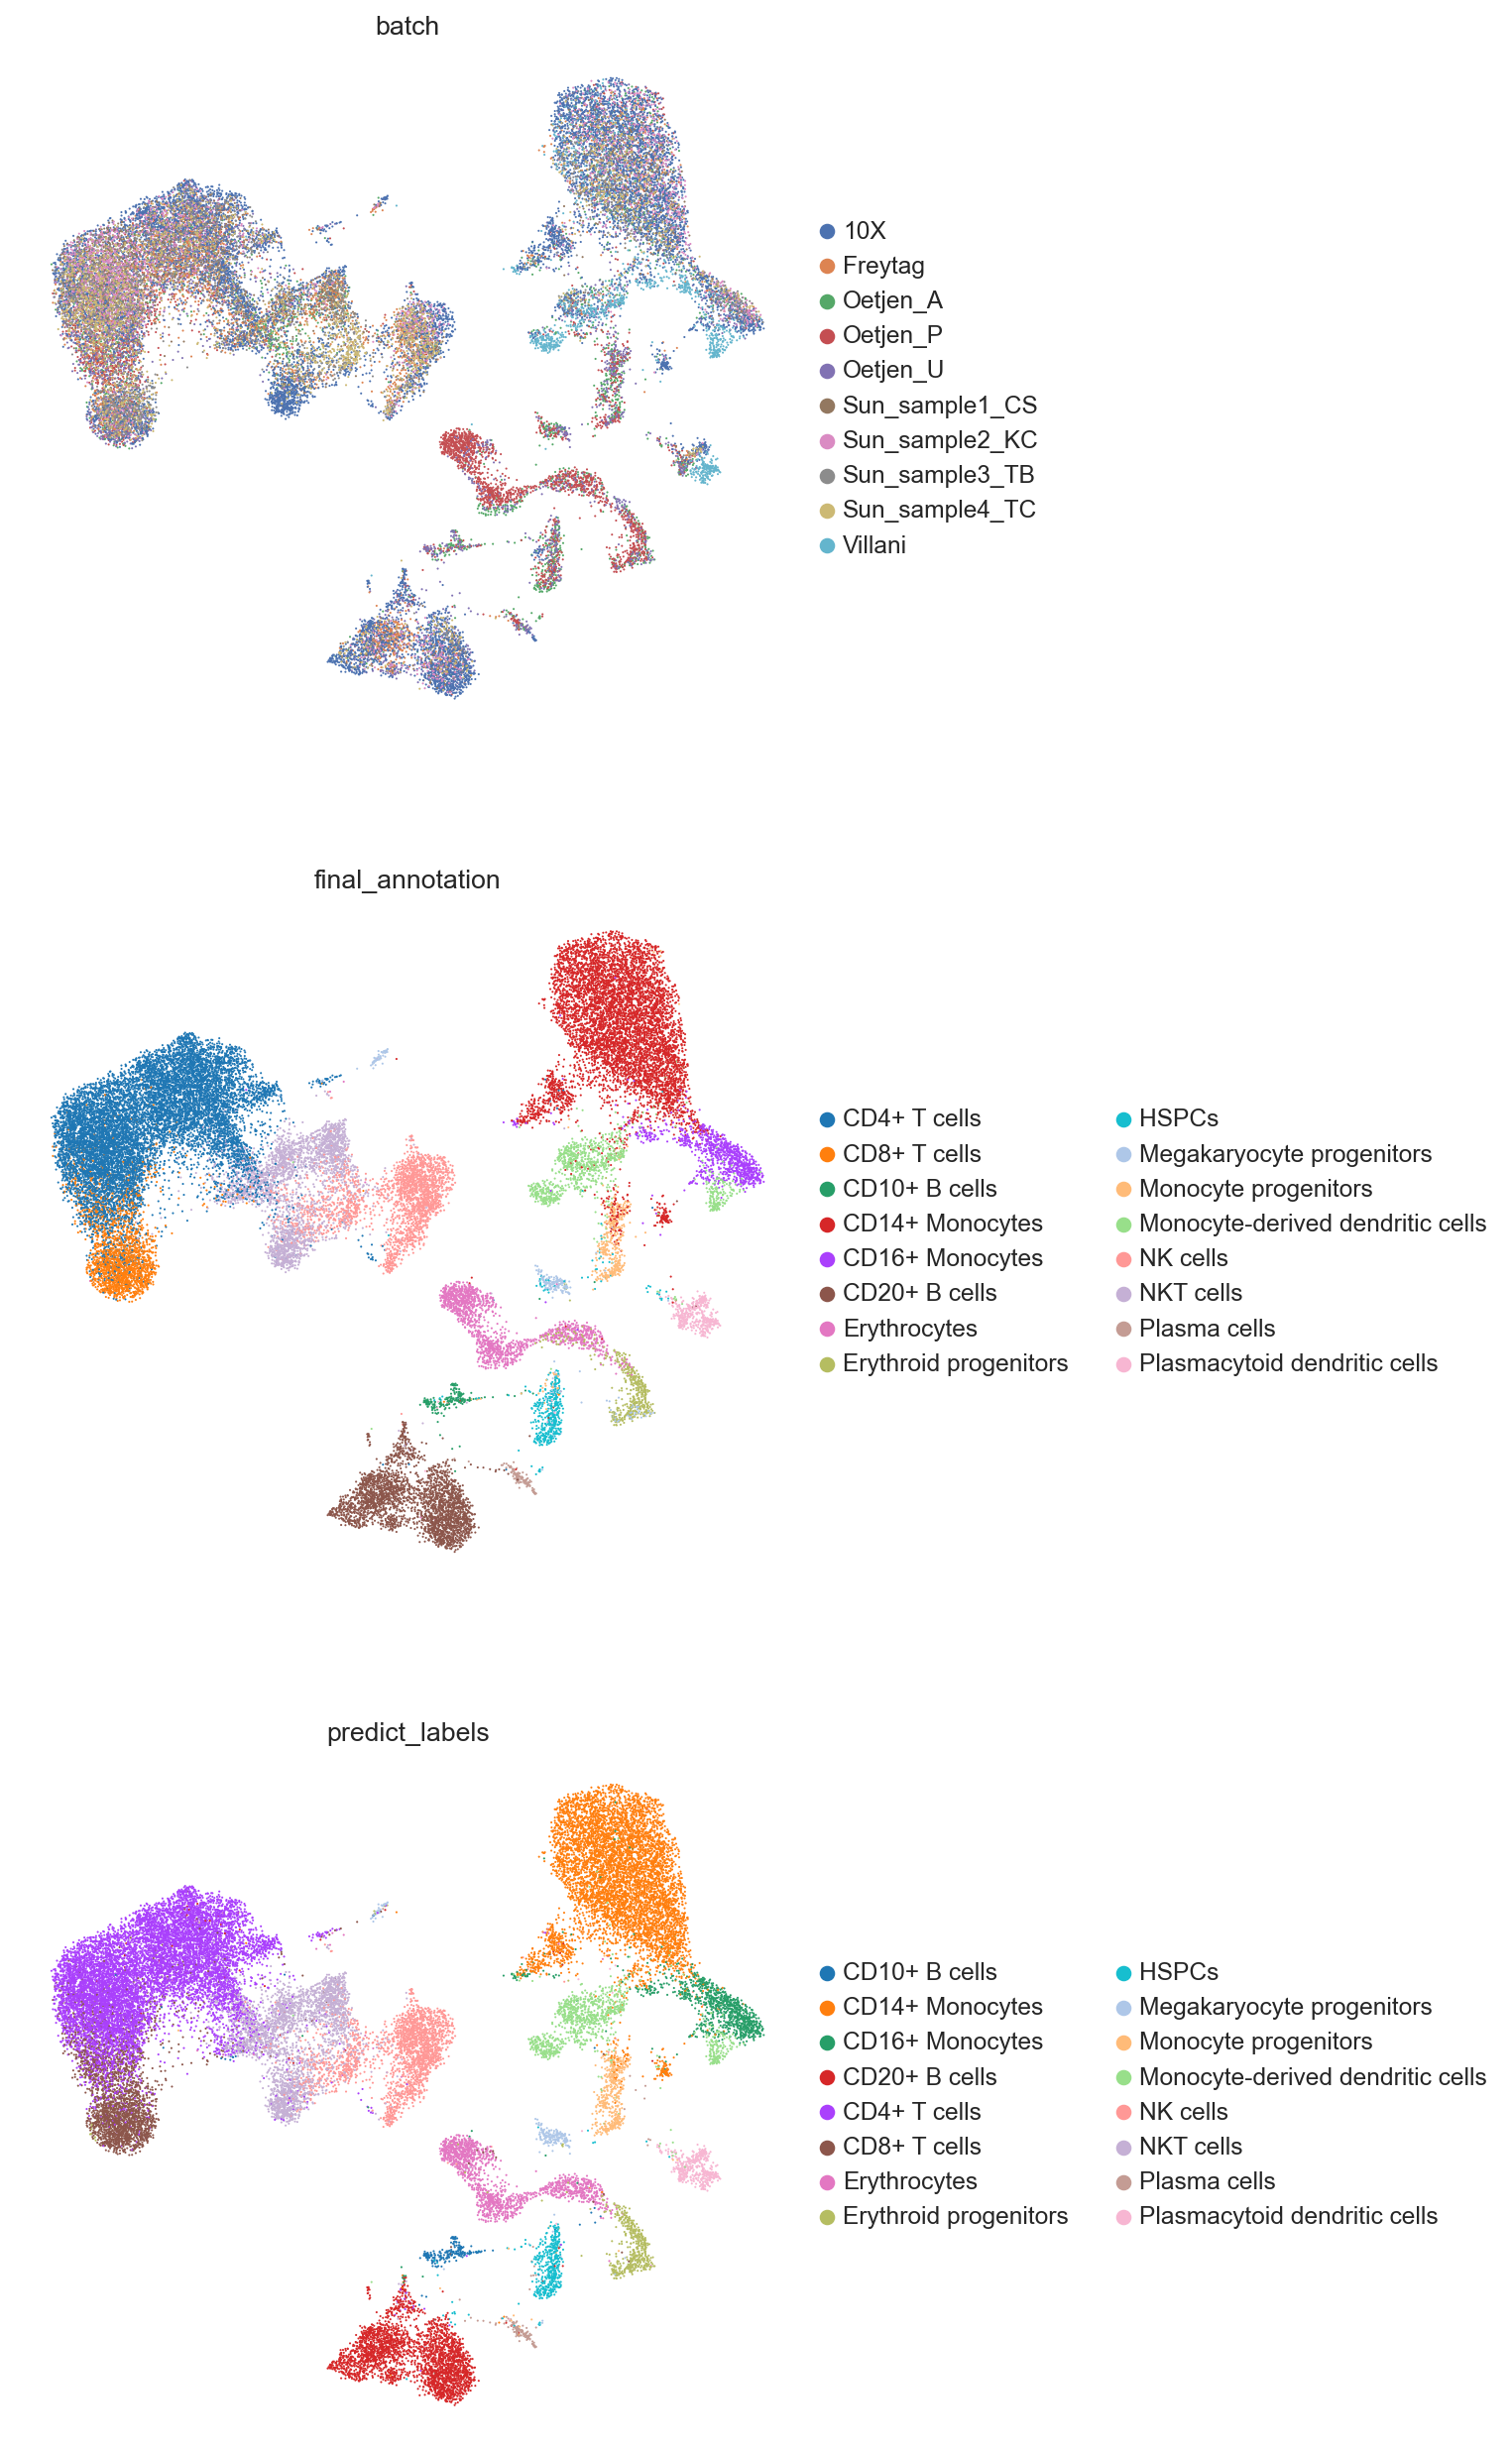

In [17]:
sc.pl.umap(adata, color=["batch", "final_annotation", "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "final_annotation" for our batch_removal procedure. There exist a "batch" obs but no "final_annotation", so we add it as a .obs of adata (but we have final_annotation in this datasets)

In [18]:
train = adata.copy()

### Preprocessing Data

In [19]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="predict_labels")

## Creating and Training the model¶

In [20]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|██▌       | 26/100 [05:51<16:39, 13.50s/it, v_num=1, train_loss_step=314, train_loss_epoch=197]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1135.172. Signaling Trainer to stop.


## Batch-Removal

In [21]:
corrected_adata = model.batch_removal()
corrected_adata

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'predict_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [22]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [23]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


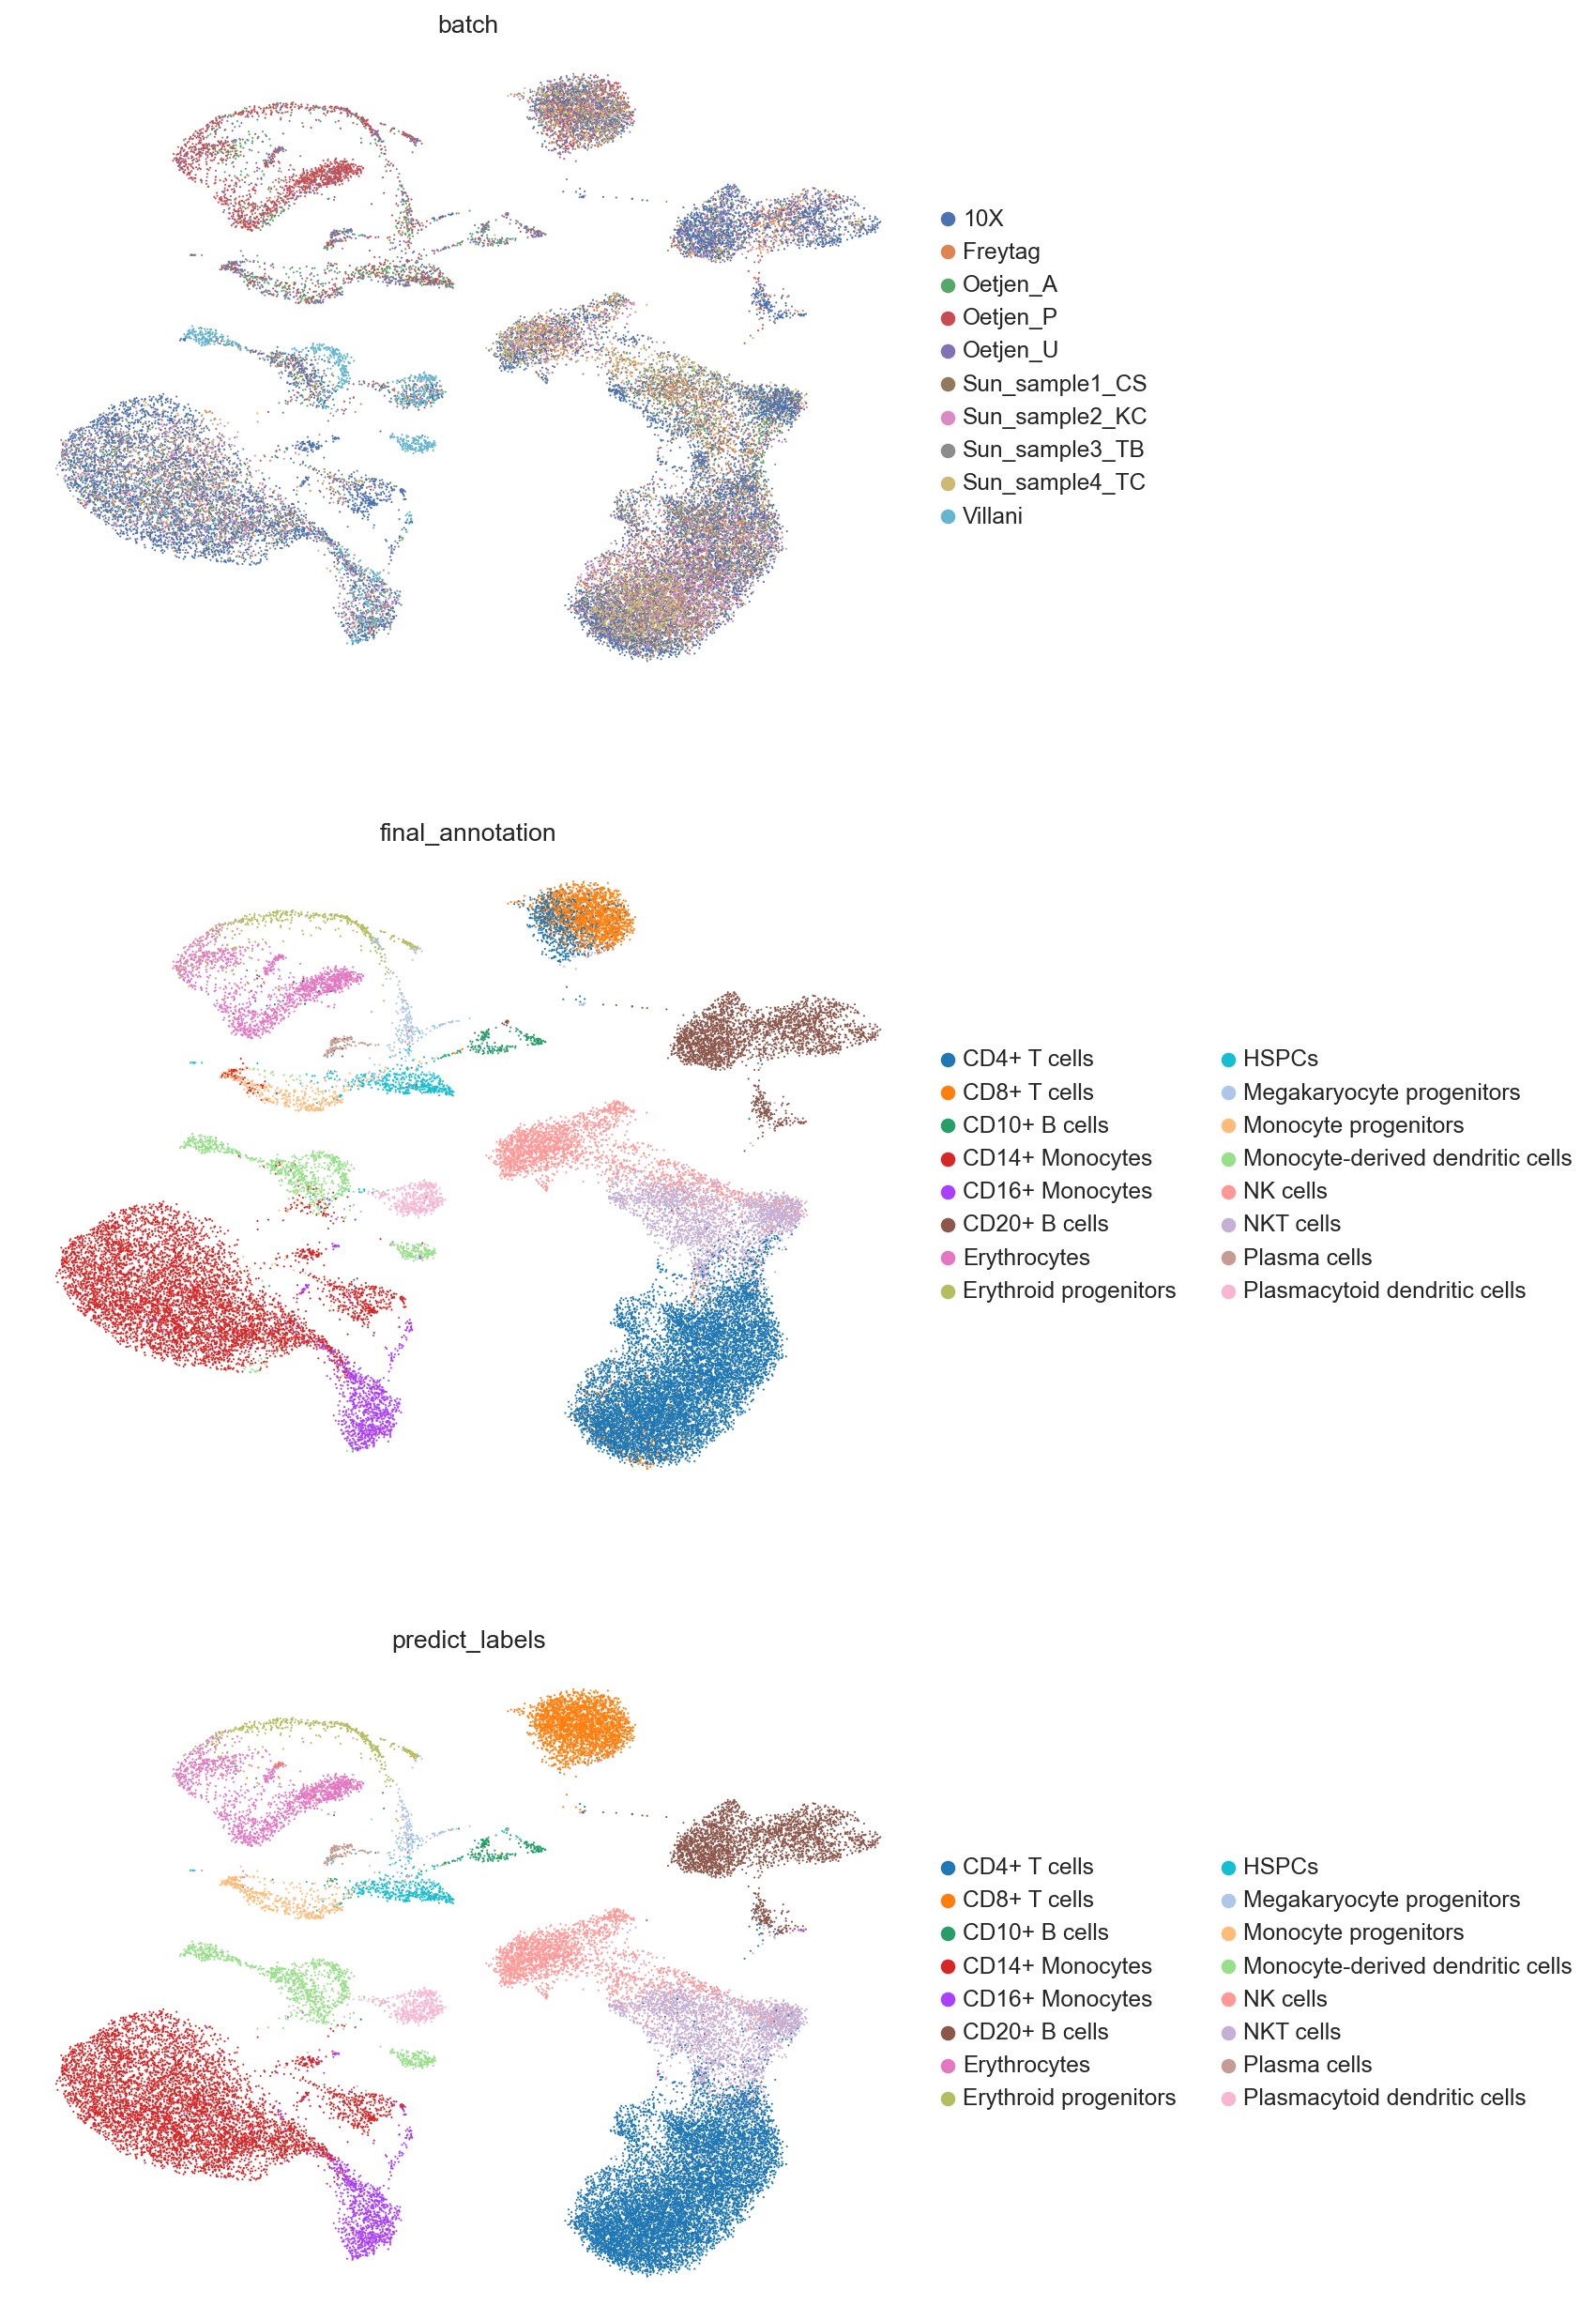

In [24]:
sc.pl.umap(corrected_adata, color=['batch', 'final_annotation', 'predict_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [25]:
pca_embeddings = pd.read_csv('../R_human_immune/embeddings/human_immune_stacas_tosica.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [26]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

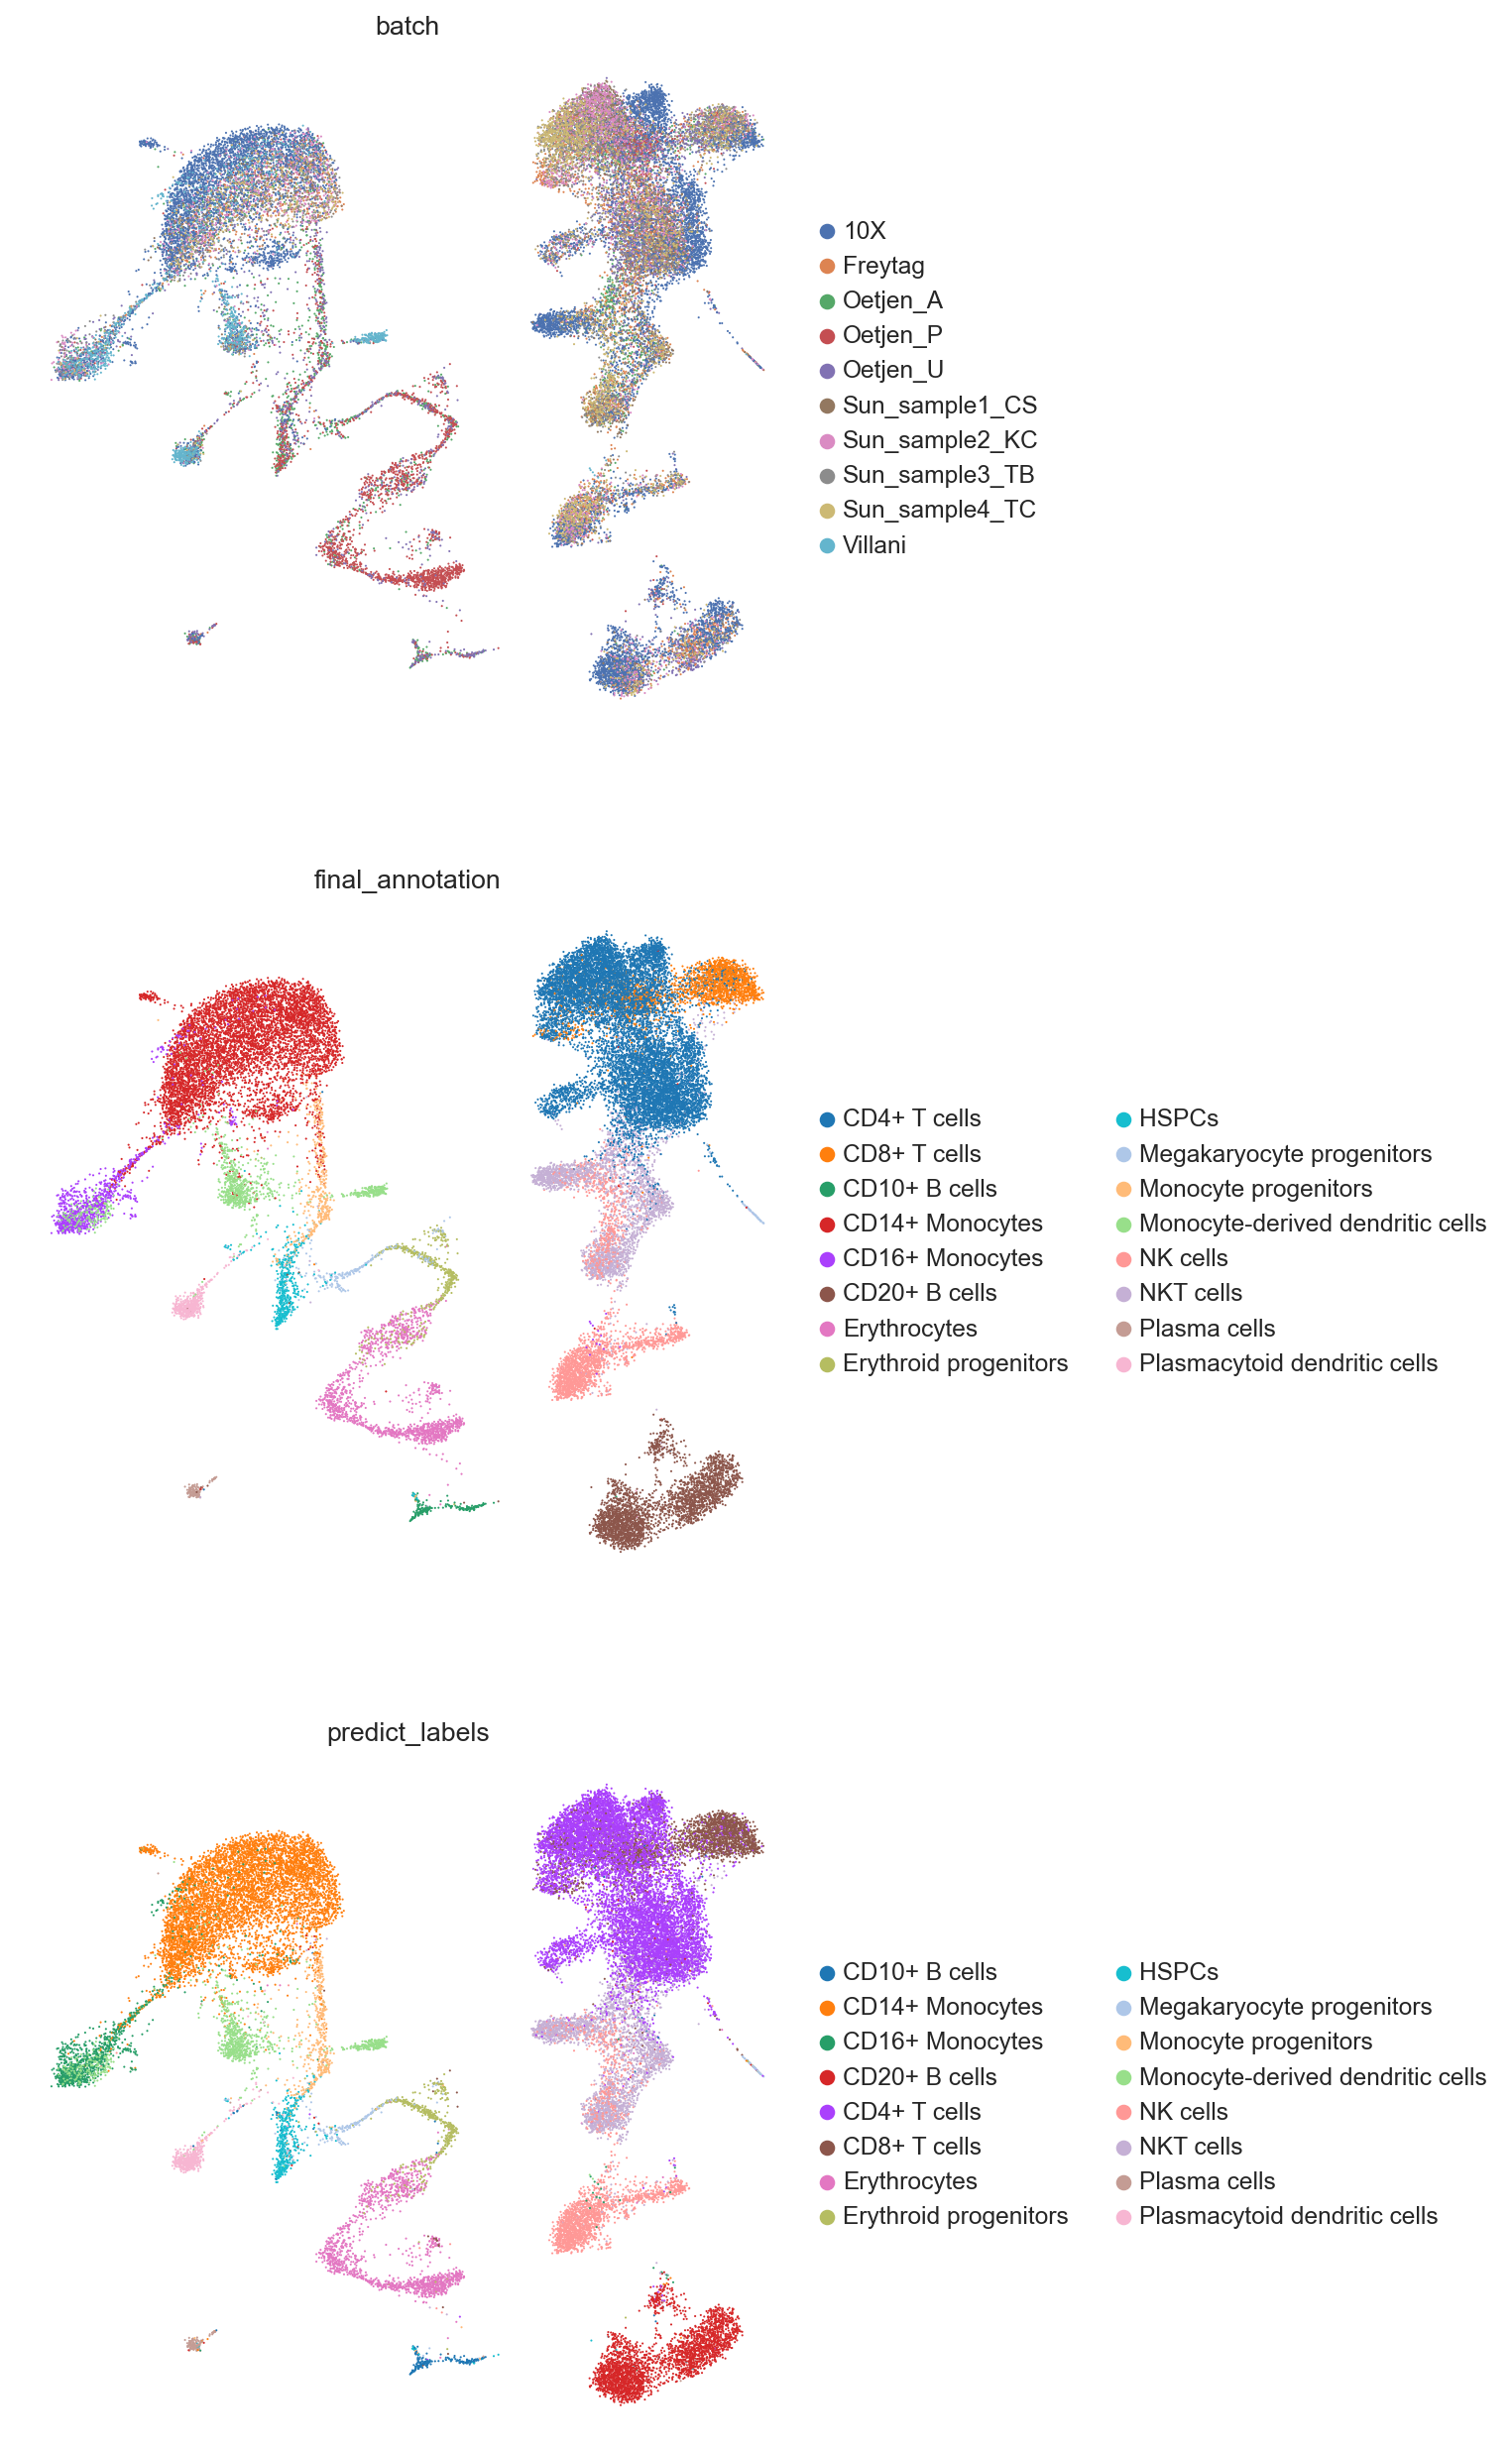

In [27]:
sc.pl.umap(adata, color=["batch", "final_annotation", "predict_labels"], frameon=False, ncols=1)

In [28]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/human_immune_tosica.csv")
